# Install libraries

In [1]:
# Tips: https://github.com/nateraw/stable-diffusion-videos/issues/168
!pip install --upgrade -q jax==0.3.25

In [2]:
!pip install flax==0.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.4/186.4 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 7.6 MB/s eta 0:00:00


In [3]:
!pip install --upgrade -q jaxlib==0.3.25

In [4]:
!pip install transformers ftfy > /dev/null

# Tips: https://github.com/huggingface/diffusers/issues/1427
#!pip uninstall -q diffusers
!pip install git+https://github.com/huggingface/diffusers > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-fb3e2fsa


In [5]:
!pip list | grep jax
!pip list | grep flax
!pip list | grep transformers
!pip list | grep diffusers
!pip list | grep ftfy

jax                           0.3.25
jaxlib                        0.3.25
flax                          0.4.2
transformers                  4.26.1
diffusers                     0.14.0.dev0
ftfy                          6.1.1


In [6]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from diffusers import FlaxStableDiffusionPipeline

# Parameter

Please set your huggingface access token (get_items) to the variable HF_ACCESS_TOKEN.  
https://huggingface.co/settings/tokens

In [16]:
HF_ACCESS_TOKEN = "hf_xxxxxxxxxxxxxxxxxxx"
SEED = 42
NUM_INFERENCE_STEPS = 50

# Setup TPU

In [7]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
import jax

In [8]:
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
assert "TPU" in device_type, "Available device is not a TPU, please select TPU accelerator."

Found 8 JAX devices of type Cloud TPU.


## Utilities

In [9]:
def sd2_inference(pipeline, prompts, params, seed = 42, num_inference_steps = 50 ):
    prng_seed = jax.random.PRNGKey(seed)
    prompt_ids = pipeline.prepare_inputs(prompts)
    params = replicate(params)
    prng_seed = jax.random.split(prng_seed, jax.device_count())
    prompt_ids = shard(prompt_ids)
    images = pipeline(prompt_ids, params, prng_seed, num_inference_steps, jit=True).images
    images = images.reshape((images.shape[0] * images.shape[1], ) + images.shape[-3:])
    images = pipeline.numpy_to_pil(images)
    return images

In [10]:
def image_grid(imgs, rows, cols, down_sample = 1 ):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    grid = grid.resize( (grid.size[0]//down_sample, grid.size[1]//down_sample) )
    return grid

# Main

In [11]:
# Load Model
# - Reference: https://github.com/huggingface/diffusers/blob/main/README.md
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
   "stabilityai/stable-diffusion-2", 
    revision="bf16",
    use_auth_token = HF_ACCESS_TOKEN,
    dtype=jnp.bfloat16,
)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Some of the weights of FlaxCLIPTextModel were initialized in bfloat16 precision from the model checkpoint at /root/.cache/huggingface/diffusers/models--stabilityai--stable-diffusion-2/snapshots/8d244c3a2b8d4e01d2983aaf0906c7a08bb8d842/text_encoder:
[('text_model', 'embeddings', 'position_embedding', 'embedding'), ('text_model', 'embeddings', 'token_embedding', 'embedding'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'bias'), ('text_model', 'encoder', 'l

In [12]:
# Dummy inference
# - This process takes several minutes to execute, because the model is prepared.
prompts = ["This is a dummy prompt."] * 8
images = sd2_inference(pipeline, prompts, params, seed = 42, num_inference_steps = 50 )

/usr/local/lib/python3.8/dist-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/usr/local/lib/python3.8/dist-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


In [13]:
prompts = [
    'realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field,',
    'a comic potrait of a female necromamcer with big and cute eyes, fine - face, realistic shaded perfect face, fine details. night setting. very anime style. realistic shaded lighting poster by ilya kuvshinov katsuhiro, magali villeneuve, artgerm, jeremy lipkin and michael garmash, rob rey and kentaro miura style, trending on art station',
    'steampunk market interior, colorful, 3 d scene, greg rutkowski, zabrocki, karlkka, jayison devadas, trending on artstation, 8 k, ultra wide angle, zenith view, pincushion lens effect',
    '“A portrait of a cyborg in a golden suit, D&D sci-fi, artstation, concept art, highly detailed illustration.”',
    'A full portrait of a beautiful post apocalyptic offworld nanotechnician, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by Krenz Cushart and Artem Demura and alphonse mucha',
    'beautiful victorian raven digital painting, art by artgerm and greg rutkowski, alphonse mucha, cgsociety',
    'ilya kuvshinov with long sky blue hair, gold eyes, professional digital painting, concept art, unreal engine 5, 8 k, cinematic, wlop, bubbles, tendrils in the background, art by greg rutkowski, pixiv art, junji ito, yoshitaka amano',
    'violet demonic card game decorative frame, violet decorative frame, card frame, card frame, card frame, card frame, card frame, card frame, card frame, card frame, card frame, card game artwork frame. 8 k, sharp high quality artwork in style of jose daniel cabrera pena and greg rutkowski, concept art, blizzard warcraft artwork, hearthstone artwork, blue sea theme'
]

In [14]:
%%time
# The inference takes about 40sec per 1batch (8images).
images = sd2_inference(pipeline, prompts, params, seed = SEED, num_inference_steps = NUM_INFERENCE_STEPS )

CPU times: user 10.8 s, sys: 24.9 s, total: 35.7 s
Wall time: 42.1 s


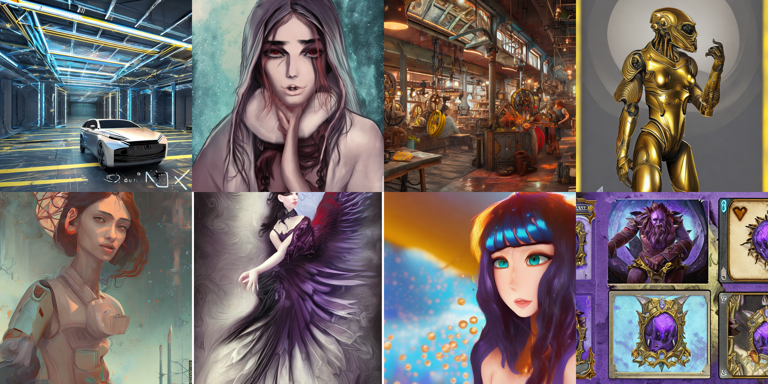

In [15]:
image_grid(images, 2, 4, down_sample=4)